In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

In [2]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
def text_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
    
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_bracket(text):
    return re.sub('\[[^]]*\]', '', text)
    
def remove_special_characters(text):
    text = text.replace('-', ' ')  
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r"\n+", " ", text)
    return text

def remove_placeholders(text):
    return re.sub(r"\[\*\*.*?\*\*\]", "", text) 


def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    word_tokens = [word for word in word_tokens if word not in stop_words]
    text = ' '.join(word_tokens) # rejoin tokens into a single string
    return text

In [4]:
def clean_text(text):
    text = text_lowercase(text)
    text = remove_placeholders(text)
    text = remove_bracket(text)
    text = remove_numbers(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    #text = remove_stopwords(text) 
    return text    

In [5]:
df['TEXT'] = df['TEXT'].apply(clean_text)

In [6]:
def multi_label_accuracy(y_true, y_pred):
    """
    Calculate multi-label accuracy.
    
    Args:
        y_true (pd.DataFrame or np.ndarray): True binary labels.
        y_pred (pd.DataFrame or np.ndarray): Predicted binary labels.
        
    Returns:
        float: Multi-label accuracy.
    """
    # Convert DataFrame to NumPy array if needed
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    n_samples = y_true.shape[0]
    accuracy_sum = 0.0
    
    for i in range(n_samples):
        true_set = set(np.where(y_true[i])[0])
        pred_set = set(np.where(y_pred[i])[0])
        
        intersection = len(true_set & pred_set)
        union = len(true_set | pred_set)
        
        if union == 0:
            accuracy_sum += 1.0
        else:
            accuracy_sum += intersection / union
    
    return accuracy_sum / n_samples

In [7]:
X = df['TEXT']
y = df.iloc[:, 3:]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Number of Observations in the Data set:" , X.values.shape[0]) 
print("Number of Observations in Train set:", X_train.shape[0])
print("Number of Observations in Test set:" , X_test.shape[0])   

Number of Observations in the Data set: 48335
Number of Observations in Train set: 33834
Number of Observations in Test set: 14501


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

In [10]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [11]:
train_lengths = np.array([ len(train_sample) for train_sample in X_train_sequences ])

print(f"Max Training Plot Length: {np.max(train_lengths)}")
print(f"Median Training Plot Length: {np.median(train_lengths)}")
print(f"Min Training Plot Length: {np.min(train_lengths)}")

Max Training Plot Length: 7043
Median Training Plot Length: 1303.0
Min Training Plot Length: 12


In [14]:
percent_documents_under_500_words = np.sum(train_lengths<=1000)/X_train.shape[0]
print(f"Median Training Review Length: {np.median(train_lengths)}")
print(f"Percentage of Reviews Under 500 words: {round(percent_documents_under_500_words*100, 2)}%")


Median Training Review Length: 1303.0
Percentage of Reviews Under 500 words: 30.31%


In [15]:
X_train_nn = pad_sequences(X_train_sequences, padding='pre', truncating='pre', maxlen=500)
X_test_nn = pad_sequences(X_test_sequences, padding='pre', truncating='pre', maxlen=500)

In [16]:
from gensim.models import KeyedVectors

# Load the binary embeddings
embedding_file = "bio_embedding_extrinsic"  
bio_embeddings = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

In [17]:
vocab_size = 20000  
embedding_dim = bio_embeddings.vector_size  

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    
    if i < vocab_size:  # Ensure the index is within vocab size
        if word in bio_embeddings.key_to_index:  # Check if word exists in BioWordVec
            embedding_matrix[i] = bio_embeddings[word]
        # If the word is not in the embeddings, it remains as a zero vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (20000, 200)


In [18]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.metrics import AUC

vocab_size = 20000
embedding_dim = 200
maxlen = 500

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim,
                weights=[embedding_matrix],
                input_length=maxlen,
                trainable=False))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20, activation='sigmoid'))  # For multi-label classification

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])

C:\Users\UserX\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 100
batch_size = 64

history = lstm_model.fit(X_train_nn, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 354s 754ms/step - auc: 0.5936 - loss: 0.5433 - val_auc: 0.7157 - val_loss: 0.4681
Epoch 2/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 288s 680ms/step - auc: 0.6917 - loss: 0.4799 - val_auc: 0.7304 - val_loss: 0.4577
Epoch 3/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 377s 892ms/step - auc: 0.7157 - loss: 0.4657 - val_auc: 0.7830 - val_loss: 0.4284
Epoch 4/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 392s 926ms/step - auc: 0.7683 - loss: 0.4401 - val_auc: 0.7999 - val_loss: 0.4145
Epoch 5/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 398s 941ms/step - auc: 0.7834 - loss: 0.4268 - val_auc: 0.8030 - val_loss: 0.4109
Epoch 6/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 403s 954ms/step - auc: 0.7909 - loss: 0.4227 - val_auc: 0.8130 - val_loss: 0.4022
Epoch 7/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 401s 948ms/step - auc: 0.8017 - loss: 0.4125 - val_auc: 0.8205 - val_loss: 0.3960
Epoch 8/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 417s 890ms/step - auc: 0.8050 - loss: 0.4110 - val_auc: 0.8233 - val_loss: 0.3930
Epoch 9/100
423/

Text(0.5, 1.0, 'Training Process - AUC')

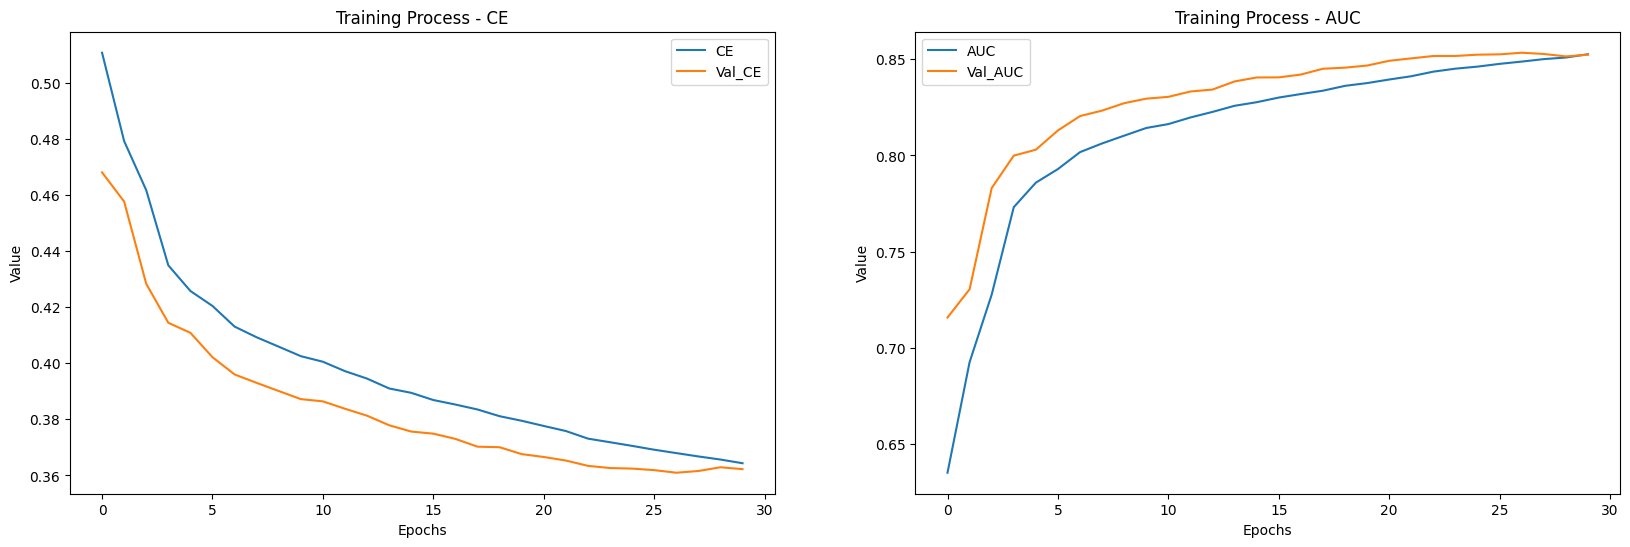

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

axs[0].plot(history.epoch, history.history['loss'])
axs[0].plot(history.epoch, history.history['val_loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].legend(["CE", "Val_CE"])
axs[0].set_title("Training Process - CE")

axs[1].plot(history.epoch, history.history['auc'])
axs[1].plot(history.epoch, history.history['val_auc'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Value")
axs[1].legend(["AUC", "Val_AUC"])
axs[1].set_title("Training Process - AUC")

In [21]:
lstm_model.evaluate(X_test_nn, y_test, batch_size=64)

227/227 ━━━━━━━━━━━━━━━━━━━━ 72s 318ms/step - auc: 0.8544 - loss: 0.3595


[0.360320508480072, 0.8549408316612244]

In [22]:
# Assuming 'model' is your LSTM model
lstm_model.save_weights('lstm_weights.weights.h5')

In [23]:
y_pred_lstm = lstm_model.predict(X_test_nn)

454/454 ━━━━━━━━━━━━━━━━━━━━ 111s 243ms/step


In [24]:
y_pred_binary = (y_pred_lstm >= 0.5).astype(int)

In [25]:
from sklearn.metrics import hamming_loss, f1_score, accuracy_score, jaccard_score

lstm_ml_acc = multi_label_accuracy(y_test, y_pred_binary)
lstm_hamming_loss = hamming_loss(y_test, y_pred_binary)

lstm_jaccard_micro = jaccard_score(y_test, y_pred_binary, average='micro')
lstm_jaccard_macro = jaccard_score(y_test, y_pred_binary, average='macro')
lstm_accuracy = accuracy_score(y_test, y_pred_binary)

lstm_f1_micro = f1_score(y_test, y_pred_binary, average='micro')
lstm_f1_macro = f1_score(y_test, y_pred_binary, average='macro')

print("Accuracy: ", lstm_accuracy)
print("\nHammilg Loss: ", lstm_hamming_loss)
print("\nJaccard Score (micro): ", lstm_jaccard_micro)
print("\nJaccard Score (macro): ", lstm_jaccard_macro)
print("\nF1 (micro) :", lstm_f1_micro)
print("\nF1 (macro) :", lstm_f1_macro)
print("\nMulti Label Accuracy :", lstm_ml_acc)

Accuracy:  0.09199365560995794

Hammilg Loss:  0.15677194676229225

Jaccard Score (micro):  0.3615889018379927

Jaccard Score (macro):  0.3199406427652724

F1 (micro) : 0.5311278629693413

F1 (macro) : 0.4198671493042073

Multi Label Accuracy : 0.36793205165467396
